In [ ]:
# !pip install -q kaggle

In [ ]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohanchopra","key":"1e638ac489d4f79e45135d70278250f6"}'}

In [ ]:
#!rm -r ~/.kaggle
#!mkdir ~/.kaggle
#!cp /content/drive/MyDrive/Concordia/AAIProject/kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

In [ ]:
#!mkdir /content/kaggle_data/
#!kaggle datasets download nih-chest-xrays/data -p /content/kaggle_data/ --unzip

mkdir: cannot create directory ‘/content/kaggle_data/’: File exists
100% 42.0G/42.0G [05:18<00:00, 183MB/s]
100% 42.0G/42.0G [05:19<00:00, 141MB/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/zipfile.py", line 1691, in _extract_member
    shutil.copyfileobj(source, target)
  File "/usr/lib/python3.7/shutil.py", line 82, in copyfileobj
    fdst.write(buf)
OSError: [Errno 28] No space left on device

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1287, in dataset_download_cli
    quiet=quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1246, in dataset_download_files
    z.extractall(effective_path)

In [ ]:
#!kaggle datasets download redwankarimsony/chestxray8-dataframe -p /content/kaggle_data/ --unzip

  0% 0.00/51.3M [00:00<?, ?B/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1287, in dataset_download_cli
    quiet=quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1236, in dataset_download_files
    self.download_file(response, outfile, quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1599, in download_file
    out.write(data)
OSError: [Errno 28] No space left on device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Nov  5 17:19:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import sys
sys.path.append('../../src/')

In [10]:
%load_ext autoreload
%autoreload 2

from train import train_model
from model import initialize_model
from utils import set_requires_grad, save_model
from data import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.random import shuffle


import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler

import torch.utils.data as td

import copy
import time
import random

from PIL import Image
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'

In [ ]:
seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [ ]:
!unzip /content/drive/MyDrive/AAI/data/resized_processed.zip -d /content/data/

In [ ]:
base_dir = "/content/drive/MyDrive/AAI"
data_dir = '/content/drive/MyDrive/AAI/data'
images_dir = "/content/data/resized_processed"

In [ ]:
train = pd.read_csv(os.path.join(data_dir,"train.csv"))
val = pd.read_csv(os.path.join(data_dir,"val.csv"))
test = pd.read_csv(os.path.join(data_dir,"test.csv"))

In [ ]:
train.head(2)

,Patient ID,label,FilePath
0,2,No Finding,images_001/images/00000002_000.png
1,5,No Finding,images_001/images/00000005_003.png


In [ ]:
# Get best num_workers
# for i in range(97):
#   start = time.time()
#   data_loader_train, data_loader_val, data_loader_test = load_data(images_dir,
#                                                                   batch_size = 96, 
#                                                                   input_size = 299, 
#                                                                   norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                                                   num_workers = i)

#   iter(data_loader_train).next()[0].shape
#   print(f"{i}: {time.time()-start}")

In [ ]:
# Models options: resnet50, inceptionv3 vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "efficient_net_b0"

# Number of classes.
num_classes = 7

# Batch Size.
batch_size = 96

# Epochs to train for.
num_epochs = 50

# Number of workers for data loader.
num_workers = 2

# Imagenet norm array passed as default value.
norm_arr=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: False - Use random weights
#                      True - Use pretrained weights 
use_pretrained = False

# Initialize the model for this run.
model_pyt, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

# lr start and end points for training.
lr_start = 0.01
lr_end = 0.001

# How many epochs to restart.
iter_restart = 10

# Multiplication factor after restart.
mul_restart = 1

# Print the model we just instantiated
#print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = input_size, 
                         norm_arr = norm_arr,
                         num_workers = num_workers)

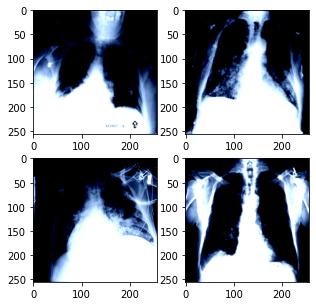

In [ ]:
plot_data_loader(data_loader_train, (2,2))

In [ ]:
plot_data_loader(data_loader_val, (2,2))

In [ ]:
plot_data_loader(data_loader_test, (2,2))

In [ ]:
# Check if GPU is available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Send model to GPU
model_pyt = model_pyt.to(device)

# Find parameters to be updated in this run.
# parameters with requires_grad = True.
params_to_update = model_pyt.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_pyt.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_pyt.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [ ]:
# 17 min 1 epoch - 128 batch size - inception
# Efficientnet b0 - batch 96 - epoch 50 - num_workers 2 - flip, auto cont, sharp - 

In [ ]:
# Observe that all parameters are being optimized
optimizer = optim.Adam(params_to_update, lr=lr_start)

# Learning rate scheduler.
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=iter_restart, T_mult=mul_restart, 
                                                           eta_min=lr_end, last_epoch=-1)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_pyt, prof, val_history, train_history = train_model(model_pyt, data_loaders, 
                                                                                                        optimizer, scheduler,
                                                                                                        criterion, 
                                                                                                        num_epochs=num_epochs,
                                                                                                        num_classes=num_classes,
                                                                                                        is_inception=(model_name=="inceptionv3"),
                                                                                                        profiler=False)

Epoch 1/50
----------
Epoch [1/50], Step [100/407], Loss: 1.5854, Accuracy: 41.00%
Epoch [1/50], Step [200/407], Loss: 1.4839, Accuracy: 43.00%
Epoch [1/50], Step [300/407], Loss: 1.4890, Accuracy: 45.00%
Epoch [1/50], Step [400/407], Loss: 1.6317, Accuracy: 39.00%
train Loss: 1.5009 Acc: 0.4746
val Loss: 1.5204 Acc: 0.4737

Epoch 2/50
----------
Epoch [2/50], Step [100/407], Loss: 1.3535, Accuracy: 52.00%
Epoch [2/50], Step [200/407], Loss: 1.3981, Accuracy: 52.00%
Epoch [2/50], Step [300/407], Loss: 1.4253, Accuracy: 47.00%
Epoch [2/50], Step [400/407], Loss: 1.3685, Accuracy: 48.00%
train Loss: 1.4348 Acc: 0.4979
val Loss: 1.5071 Acc: 0.4739

Epoch 3/50
----------
Epoch [3/50], Step [100/407], Loss: 1.4114, Accuracy: 45.00%
Epoch [3/50], Step [200/407], Loss: 1.4723, Accuracy: 43.00%
Epoch [3/50], Step [300/407], Loss: 1.3951, Accuracy: 48.00%
Epoch [3/50], Step [400/407], Loss: 1.4112, Accuracy: 44.00%
train Loss: 1.4038 Acc: 0.5094
val Loss: 1.4415 Acc: 0.4974

Epoch 4/50
--------

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=50))

In [ ]:
val_acc_history

In [ ]:
val_loss_history

In [ ]:
train_acc_history

In [ ]:
train_loss_history

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
vhist = [h.cpu().numpy() for h in val_acc_history]
thist = []
thist = [h.cpu().numpy() for h in train_acc_history]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
#plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
vhist

In [ ]:
thist

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
vhist = [h.cpu().numpy() for h in val_loss_history]
thist = []
thist = [h.cpu().numpy() for h in train_loss_history]

plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
#plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
vhist

In [ ]:
thist

In [ ]:
save_model(model_ft.state_dict(), '/content/drive/MyDrive/AAI/', 
           'Efficientnet_b0_batch_96_epoch_50_num_workers_2_flip_auto_cont_sharp_model_weights.pth')